<a href="https://colab.research.google.com/github/erfanera/SlumImprovment/blob/main/GraphOperation/Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install osmnx geopandas matplotlib networkx

In [4]:
import networkx as nx

In [11]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import pandas as pd

# Define the location
place_name = "Embajadores, Madrid, Spain"

# Retrieve the street network from the specified location, network_type='drive' means only drivable roads are retrieved.
# Use the graph_from_place method from the osmnx library to get the street network graph, and convert it to GeoDataFrames of nodes and edges.
graph = ox.graph_from_place(place_name, network_type='drive')


In [39]:
nodes, edges = ox.graph_to_gdfs(graph, nodes=True, edges=True)

#print(edges)
nodes_length = len(nodes)

# Convert the 'u' and 'v' columns to a list of tuples
edgeMap  = []
for u, v, key, data in graph.edges(keys=True, data=True):
  edgeMap.append((u,v))
print(edgeMap)
# Retrieve all buildings
buildings = ox.features_from_place(place_name, {"building": True})

# Extract the 'building' column and create a list of functions (building types)
functions = list(buildings['building'])

# Convert buildings to DataFrame for better display
building_df = buildings[['name', 'building', 'geometry']]

# Get all unique building types (functions)
allFunctions = set(functions)

# Define house and amenity keywords
houseKeywords = ["apartments", "residential", "hotel", "house"]
amenityKeywords = allFunctions - set(houseKeywords)

# Get positions of road nodes
roadNodesPosition = [(geom.x, geom.y) for geom in nodes.geometry]

# Modify building functions to categorize into 'house' or 'amenity'
ModifiedFunctions = ["house" if func in houseKeywords else "amenity" for func in functions]
building_centers = [(cent.x, cent.y) for cent in buildings.centroid]
# Print modified functions (for debugging)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(21734290, 390826846), (21734290, 21951394), (21734297, 351959168), (21734308, 21734309), (21734309, 21734297), (21734309, 21951420), (21759574, 21759575), (21759574, 21941563), (21759575, 21941518), (21759575, 26494668), (21759575, 632467188), (21759692, 21759693), (21941518, 632467189), (21941518, 21941530), (21941530, 21941604), (21941530, 3190460047), (21941563, 21941572), (21941563, 3190460047), (21941563, 21759574), (21941572, 26493399), (21941577, 26310534), (21941577, 21941572), (21941577, 26493400), (21941587, 21941619), (21941587, 26493397), (21941587, 11688431397), (21941597, 21941604), (21941597, 3190460047), (21941604, 21941807), (21941604, 21943191), (21941619, 21941597), (21941630, 21941647), (21941647, 21941676), (21941647, 26310495), (21941676, 622103570), (21941676, 21941619), (21941787, 21941597), (21941807, 21947287), (21941807, 21941787), (21941865, 21941807), (21941865, 21943191), (21942002, 26494709), (21943059, 21941787), (21943059, 21947451), (21943161, 219431

<ipython-input-39-d05609234198>:32: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  building_centers = [(cent.x, cent.y) for cent in buildings.centroid]


In [38]:
len(nodes)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


226

In [83]:
G = nx.Graph()

# Make sure roadNodesPosition is a dictionary with node positions
# Example: roadNodesPosition = {node_id1: (x1, y1), node_id2: (x2, y2), ...}
roadNodesPosition = {node: (data['x'], data['y']) for node, data in nodes.iterrows()}

# Add nodes with positions
for node in nodes.index:
    if node in roadNodesPosition:
        G.add_node(node, pos=roadNodesPosition[node])
    else:
        print(f"Node {node} has no position in roadNodesPosition")

# Add edges
# Make sure edgeMap is a list of tuples where each tuple contains two node IDs
# Example: edgeMap = [(node1, node2), (node3, node4), ...]
for edge in edgeMap:
    u, v = edge
    if u in G.nodes and v in G.nodes:
        G.add_edge(u, v)
    else:
        print(f"Edge {edge} contains a node that does not exist in the graph")

# Visualize the graph


In [84]:
for i in range(len(building_centers)):
  G.add_node(nodes_length+i, pos = building_centers[i] , function = ModifiedFunctions[i])


In [85]:
import copy
def connect_new_points_to_graph2(graph, houses, amenities):

    # Create a new graph to store results
    new_graph = copy.deepcopy(graph)

    for point in houses:
        closest_node = None
        min_distance = float('inf')
        new_graph.add_node(point, function="house", pos = point)# Calculate the distance of the point to each node in the graph
        for node in graph.nodes():
            node_pos = graph.nodes[node]['pos']
            distance = math.sqrt((node_pos[0] - point[0]) ** 2 + (node_pos[1] - point[1]) ** 2)

            # Update the closest node if this node is closer
            if distance < min_distance:
                closest_node = node
                min_distance = distance

        # Connect the point to the closest node in the new graph
        if closest_node is not None:

            new_graph.add_node(closest_node, pos=graph.nodes[closest_node]['pos'])  # Add the closest node
            new_graph.add_node(point, pos=point, function = "house")  # Add the new point
            new_graph.add_edge(closest_node, point, weight=min_distance, function = "house")  # Add an edge between them
    for point in amenities:
        closest_node = None
        min_distance = float('inf')
        new_graph.add_node(point, function="amenity", pos = point)# Calculate the distance of the point to each node in the graph
        for node in graph.nodes():
            node_pos = graph.nodes[node]['pos']
            distance = math.sqrt((node_pos[0] - point[0]) ** 2 + (node_pos[1] - point[1]) ** 2)

            # Update the closest node if this node is closer
            if distance < min_distance:
                closest_node = node
                min_distance = distance

        # Connect the point to the closest node in the new graph
        if closest_node is not None:

            new_graph.add_node(closest_node, pos=graph.nodes[closest_node]['pos'])  # Add the closest node
            new_graph.add_node(point, pos=point, function = "amenity")  # Add the new point
            new_graph.add_edge(closest_node, point, weight=min_distance, function = "amenity")  # Add an edge between them


    return new_graph


def connect_new_points_to_graph(graph, new_points):
    """
    Creates a new graph where each new point is connected to the closest node from the original graph.

    :param graph: A NetworkX graph where nodes have a 'pos' attribute containing their coordinates.
    :param new_points: A list of tuples, where each tuple represents the coordinates of a new point.
    :return: A new NetworkX graph with only the new points and their closest existing nodes.
    """
    # Create a new graph to store results
    new_graph = nx.Graph()

    for point in new_points:
        closest_node = None
        min_distance = float('inf')

        # Calculate the distance of the point to each node in the graph
        for node in graph.nodes():
            node_pos = graph.nodes[node]['pos']
            distance = math.sqrt((node_pos[0] - point[0]) ** 2 + (node_pos[1] - point[1]) ** 2)

            # Update the closest node if this node is closer
            if distance < min_distance:
                closest_node = node
                min_distance = distance

        # Connect the point to the closest node in the new graph
        if closest_node is not None:
            new_graph.add_node(closest_node, pos=graph.nodes[closest_node]['pos'])  # Add the closest node
            new_graph.add_node(point, pos=point)  # Add the new point
            new_graph.add_edge(closest_node, point, weight=min_distance)  # Add an edge between them

    return new_graph

In [86]:
import numpy as np
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt

def closest_point_on_segment(point, segment):
    """Find the closest point on a line segment to a given point."""
    p1 = np.array(segment[0])
    p2 = np.array(segment[1])
    p3 = np.array(point)
    d = p2 - p1
    l2 = np.dot(d, d)
    if l2 == 0.0:
        return tuple(p1)
    t = max(0, min(1, np.dot(p3 - p1, d) / l2))
    projection = p1 + t * d
    return tuple(projection)

def add_split_edge(G, u, v, new_node_id, alone_node):
    """Add a split edge to the graph."""
    # Find the closest point on the edge (u, v) to alone_node
    u_pos = G.nodes[u]['pos']
    v_pos = G.nodes[v]['pos']
    alone_node_pos = G.nodes[alone_node]['pos']

    closest_point = closest_point_on_segment(alone_node_pos, [u_pos, v_pos])

    # Add the new node at the closest point
    G.add_node(new_node_id, pos=closest_point)

    # Remove the original edge
    G.remove_edge(u, v)

    # Add new edges
    G.add_edge(u, new_node_id)
    G.add_edge(new_node_id, v)
    G.add_edge(new_node_id, alone_node)

def process_graph(G):
    """Process the graph to add edges for nodes with 'amenity' or 'house' attribute."""
    new_node_id = max(G.nodes) + 1  # Start new node IDs from the highest existing node ID + 1
    for node, data in G.nodes(data=True):
        if data.get('function') in ['amenity', 'house']:
            closest_edge = None
            min_distance = float('inf')
            alone_node_pos = G.nodes[node]['pos']

            # Find the closest edge to the node
            for u, v, edge_data in G.edges(data=True):
                u_pos = G.nodes[u]['pos']
                v_pos = G.nodes[v]['pos']
                line = LineString([u_pos, v_pos])
                point = Point(alone_node_pos)
                distance = point.distance(line)
                if distance < min_distance:
                    min_distance = distance
                    closest_edge = (u, v)

            # Add the split edge if a closest edge is found
            if closest_edge:
                u, v = closest_edge
                add_split_edge(G, u, v, new_node_id, node)
                new_node_id += 1

    return G

In [88]:
def closest_point_on_segment(point, segment):
    """Find the closest point on a line segment to a given point."""
    p1 = np.array(segment[0])
    p2 = np.array(segment[1])
    p3 = np.array(point)
    d = p2 - p1
    l2 = np.dot(d, d)
    if l2 == 0.0:
        return tuple(p1)
    t = max(0, min(1, np.dot(p3 - p1, d) / l2))
    projection = p1 + t * d
    return tuple(projection)

def add_split_edge(G, u, v, new_node_id, alone_node):
    """Add a split edge to the graph."""
    # Find the closest point on the edge (u, v) to alone_node
    u_pos = G.nodes[u]['pos']
    v_pos = G.nodes[v]['pos']
    alone_node_pos = G.nodes[alone_node]['pos']

    closest_point = closest_point_on_segment(alone_node_pos, [u_pos, v_pos])

    # Add the new node at the closest point
    G.add_node(new_node_id, pos=closest_point)

    # Remove the original edge
    G.remove_edge(u, v)

    # Add new edges
    G.add_edge(u, new_node_id)
    G.add_edge(new_node_id, v)
    G.add_edge(new_node_id, alone_node)

def process_graph(G):
    """Process the graph to add edges for nodes with 'amenity' or 'house' attribute."""
    new_node_id = max(G.nodes) + 1  # Start new node IDs from the highest existing node ID + 1
    nodes_to_process = [node for node, data in G.nodes(data=True) if data.get('function') in ['amenity', 'house']]

    for node in nodes_to_process:
        closest_edge = None
        min_distance = float('inf')
        alone_node_pos = G.nodes[node]['pos']

        # Find the closest edge to the node
        for u, v, edge_data in G.edges(data=True):
            u_pos = G.nodes[u]['pos']
            v_pos = G.nodes[v]['pos']
            line = LineString([u_pos, v_pos])
            point = Point(alone_node_pos)
            distance = point.distance(line)
            if distance < min_distance:
                min_distance = distance
                closest_edge = (u, v)

        # Add the split edge if a closest edge is found
        if closest_edge:
            u, v = closest_edge
            add_split_edge(G, u, v, new_node_id, node)
            new_node_id += 1

    return G

/usr/local/lib/python3.10/dist-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


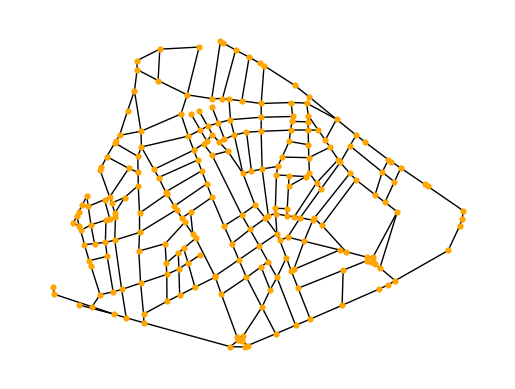

In [89]:
G = process_graph(G)

# Visualize the updated graph
fig, ax = plt.subplots()
pos = nx.get_node_attributes(G, 'pos')
nx.draw(Gn, pos, with_labels=False, node_color='orange', edge_color='black', node_size=12, ax=ax)
plt.show()

In [60]:
house_nodes = []
amenity_nodes = []
# Iterate through the nodes in the graph
for node, data in graph.nodes(data=True):
    if data.get('function') == 'house':
        house_nodes.append(node)
    if data.get('function') == 'amenity':
        amenity_nodes.append(node)

TypeError: connect_new_points_to_graph() takes 2 positional arguments but 3 were given

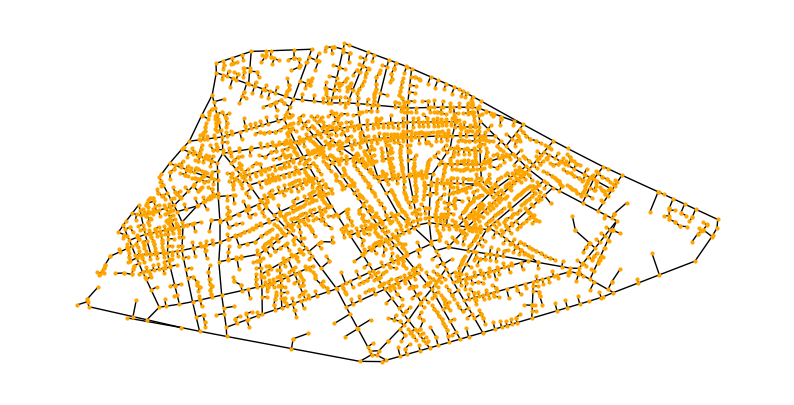

In [92]:
fig = plt.figure(figsize=(10,5))
ax = plt.gca()

# Get node positions
smallpos = nx.get_node_attributes(G, 'pos')
if not smallpos:
    print("No positions found for nodes")

# Draw the graph
nx.draw(G, smallpos, with_labels=False, node_color="orange", edge_color='black', node_size=4, ax=ax)
#plt.savefig('allNodes.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [81]:
G = process_graph(G)

# Visualize the updated graph
fig, ax = plt.subplots()
pos = nx.get_node_attributes(Gn, 'pos')
nx.draw(Gn, pos, with_labels=False, node_color='orange', edge_color='black', node_size=12, ax=ax)
plt.show()

RuntimeError: dictionary changed size during iteration

In [ ]:


def connect_new_points_to_graph(graph, new_points):
    """
    Creates a new graph where each new point is connected to the closest node from the original graph.

    :param graph: A NetworkX graph where nodes have a 'pos' attribute containing their coordinates.
    :param new_points: A list of tuples, where each tuple represents the coordinates of a new point.
    :return: A new NetworkX graph with only the new points and their closest existing nodes.
    """
    # Create a new graph to store results
    new_graph = nx.Graph()s

    for point in new_points:
        closest_node = None
        min_distance = float('inf')

        # Calculate the distance of the point to each node in the graph
        for node in graph.nodes():
            node_pos = graph.nodes[node]['pos']
            distance = math.sqrt((node_pos[0] - point[0]) ** 2 + (node_pos[1] - point[1]) ** 2)

            # Update the closest node if this node is closer
            if distance < min_distance:
                closest_node = node
                min_distance = distance

        # Connect the point to the closest node in the new graph
        if closest_node is not None:
            new_graph.add_node(closest_node, pos=graph.nodes[closest_node]['pos'])  # Add the closest node
            new_graph.add_node(point, pos=point)  # Add the new point
            new_graph.add_edge(closest_node, point, weight=min_distance)  # Add an edge between them

    return new_graph
